## Import Libraries

In [ ]:
%matplotlib inline
import numpy as np
import networkx as nx
from mpl_toolkits.basemap import Basemap
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = (8,6)
from gurobipy import *

## Import files

In [27]:
G2 = np.loadtxt('HW2_problem 2.txt')
G2 = nx.from_numpy_matrix(G2[34:68, 0:34])

with open('HW2_tsp.txt') as lat_lon_file:
	data = lat_lon_file.read().splitlines()
	data = data[10:]
	for x in range(len(data)):
		data[x] = data[x].split()
	for x in range(len(data)):
		data[x][1] = float(data[x][1]) / 1000
		data[x][2] = float(data[x][2]) / 1000

## Centrality Measures

In [3]:
betw = nx.betweenness_centrality(G2, normalized = True)
print(sorted(betw, key = betw.get, reverse = True)[:2])

[0, 33]


This implies that nodes 0 and 33 with the highest betweenness centrality, have large influence and control over the transfer of information within the network. Basically, each of these two nodes are more likely to be used as a medium to deliver information or data from one individual/group to another within the organization, due to their advantaged position.

In [4]:
flow = nx.current_flow_closeness_centrality(G2)
print(sorted(flow, key = flow.get, reverse = True)[:2])

[33, 0]


This suggests that nodes 33 and 0 are the most efficient when it comes to communication. These nodes are well-positioned to obtain and spread information among other individuals/groups in the network. 

In [5]:
eigenvector = nx.eigenvector_centrality(G2)
print(sorted(eigenvector, key = eigenvector.get, reverse = True)[:2])

[33, 2]


This indicates that nodes 33 and 2 with the highest eigenvector centrality, have well-connected and strong influential neighbors in the network.

In [6]:
closeness = nx.closeness_centrality(G2, normalized = True)
print(sorted(closeness, key = closeness.get, reverse = True)[:2])

[0, 2]


This implies that nodes 0 and 2 are the closest to all other individuals/groups within the organization.

## Final Interpretation

Note that **current-flow closeness centrality** is more relevant than **closeness centrality** in this case, because what is most likely flowing through this network (organization) is information. In fact, information can be spread through multiple sources, so we need to consider all paths in the network, not only the shortest path (geodesic).
Also, since the same few nodes appear in all of the centrality measures, we can conclude that actors 33, 0, and 2 have leadership roles within the network. Information flows through them, and they control communication flow. These three nodes are the most central and important actors in the network.

## 3_a: Plot the latitude and longitude scatter plot

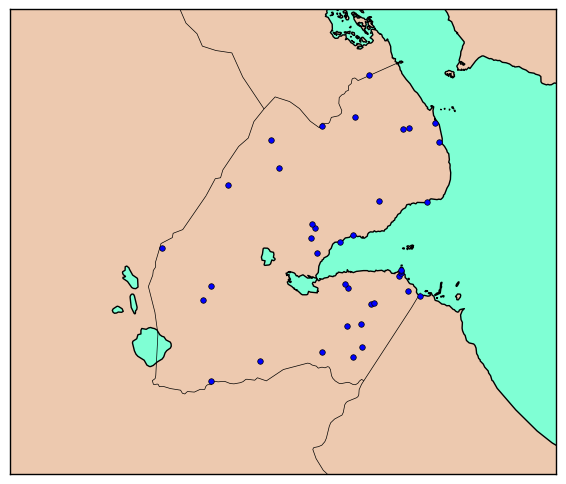

In [28]:
my_map = Basemap(projection='merc', lat_0 = 11, lon_0 = 42,
    resolution = 'h', area_thresh = 0.1,
    llcrnrlon=41, llcrnrlat=10.5,
    urcrnrlon=44, urcrnrlat=13)
 
my_map.drawcoastlines()
my_map.drawcountries()
my_map.fillcontinents(color = '#EDC9AF', lake_color = 'aquamarine')
my_map.drawmapboundary(fill_color = 'aquamarine')
 
lats = []
for x in range (len(data)):
	lats.append(data[x][1])
lons = []
for x in range (len(data)):
	lons.append(data[x][2])
    
x,y = my_map(lons, lats)
my_map.plot(x, y, 'bo', markersize=4)
 
plt.show()

## 3_c: Solve the Traveling Salesman Problem with integer programming
Code adapted from http://examples.gurobi.com/traveling-salesman-problem/

In [ ]:
# Find distance between two points
def distance (df, origin, destination):
	return df.iloc[origin,destination]

# Eliminate subtours that are not visiting all the nodes
def subtour_eliminate(model, where):
	if where == GRB.callback.MIPSOL:
		selected = []
		# list of edges included in solution
		for origin in range(n):
			solution = model.cbGetSolution
            ([model._vars[origin,destination]
              for destination in range(n)])
			selected += [(origin,destination)
                         for destination in range(n)
                         if solution[destination] > 0.5]
		# find shortest cycle in edge list
		tour = subtour(selected)
		if len(tour) < n:
			print()
			# add a subtour elimination constraint
			expr = 0
			for origin in range(len(tour)):
				for destination in range(origin+1, 
                                         len(tour)):
					expr += model._vars[tour[origin], 
                                        tour[destination]]
			model.cbLazy(expr <= len(tour)-1)

# Find the shortest subtour
def subtour(edges):
	visited = [False]*n
	cycles = []
	lengths = []
	selected = [[] for i in range(n)]
	for x,y in edges:
		selected[x].append(y)
	while True:
		current = visited.index(False)
		thiscycle = [current]
		while True:
			visited[current] = True
			neighbors = [node for node in selected[current] 
                         if not visited[node]]
			if len(neighbors) == 0:
				break
			current = neighbors[0]
			thiscycle.append(current)
		cycles.append(thiscycle)
		lengths.append(len(thiscycle))
		if sum(lengths) == n:
			break
	return (cycles[lengths.index(min(lengths))])

# Create variables
m = Model()
n = len(distances)
vars = {}
for origin in range(n):
   for destination in range(origin+1):
     vars[origin,destination] = m.addVar(obj=distance(distances, 
                                                    origin, destination),
                            vtype=GRB.BINARY,
                            name='e'+str(origin)+'_'+str(destination))
     vars[destination,origin] = vars[origin,destination]
   m.update()

# Add constraint to prevent loops 
# Make sure to visit each city exactly once (degree-2 constraint)
for origin in range(n):
  m.addConstr(quicksum(vars[origin,destination] 
                       for destination in range(n)) == 2)
  vars[origin,origin].ub = 0

m.update()

# Find optimal tour
m._vars = vars
m.params.LazyConstraints = 1
m.optimize(subtour_eliminate)

solution = m.getAttr('x', vars)
selected = [(origin,destination) 
            for origin in range(n) 
            for destination in range(n) 
            if solution[origin,destination] > 0.5]


## 3_d: Plot the optimal tour

In [ ]:
for i in selected:
	xs = []
	ys = []

	xpoint0, ypoint0 = djibouti(lons[i[0]], lats[i[0]])
	xs.append(xpoint0)
	ys.append(ypoint0)

	xpoint1, ypoint1 = djibouti(lons[i[1]], lats[i[1]])
	xs.append(xpoint1)
	ys.append(ypoint1)

	djibouti.plot(xs, ys, color = 'grey', linewidth = 1)

plt.savefig('Djibouti.png')
plt.close()

<img src="Djibouti.png" width="1000" height="200" />